In [10]:
!pip install pandas numpy yfinance scipy
!pip install nbformat>=4.2.0



In [11]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import yfinance as yf
from scipy.stats import kurtosis, skew

class SPYDataAnalyzer:
    def __init__(self, years=10, cache_file='spy_data.csv'):
        self.years = years
        self.cache_file = cache_file
        self.data = None
    
    def fetch_data(self):
        # Check if data is cached and is up-to-date
        if os.path.exists(self.cache_file):
            modified_time = datetime.fromtimestamp(os.path.getmtime(self.cache_file))
            if datetime.now() - modified_time < timedelta(days=1):
                self.data = pd.read_csv(self.cache_file, parse_dates=['Date'], index_col='Date')
                return

        # Fetch data from Yahoo Finance
        end_date = datetime.now()
        start_date = end_date - timedelta(days=self.years * 365)
        spy = yf.download('SPY', start=start_date, end=end_date)
        self.data = spy[['Open', 'High', 'Low', 'Close']]
        self.data.to_csv(self.cache_file)
    
    def calculate_indicators(self):
        if self.data is None:
            raise ValueError("No data available. Please fetch data first.")
        
        # Calculate moving averages
        self.data['20_MA'] = self.data['Close'].rolling(window=20).mean()
        self.data['52_Week_MA'] = self.data['Close'].rolling(window=260).mean()
        
        # Calculate Bollinger Bands for 20-day and 52-week
        self.data['20_Upper_BB'] = self.data['20_MA'] + 2 * self.data['Close'].rolling(window=20).std()
        self.data['20_Lower_BB'] = self.data['20_MA'] - 2 * self.data['Close'].rolling(window=20).std()
        self.data['52_Upper_BB'] = self.data['52_Week_MA'] + 2 * self.data['Close'].rolling(window=260).std()
        self.data['52_Lower_BB'] = self.data['52_Week_MA'] - 2 * self.data['Close'].rolling(window=260).std()
        
        # Calculate daily returns and other statistics
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Cumulative_Return'] = (1 + self.data['Daily_Return']).cumprod() - 1
        self.data['Std_Dev'] = self.data['Daily_Return'].rolling(window=20).std()
        
        # Calculate statistical metrics only where there are enough data points
        self.data['Skewness'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: skew(x.dropna()), raw=False)
        self.data['Kurtosis'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: kurtosis(x.dropna()), raw=False)
        self.data['Positive_Return_Percentage'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: (x > 0).mean() * 100, raw=False)
        
        # Calculate Kelly ratio and fraction based on available returns
        win_rate = self.data['Positive_Return_Percentage'] / 100
        loss_rate = 1 - win_rate
        avg_win = self.data[self.data['Daily_Return'] > 0]['Daily_Return'].mean()
        avg_loss = abs(self.data[self.data['Daily_Return'] <= 0]['Daily_Return'].mean())
        self.data['Kelly_Ratio'] = win_rate - (loss_rate / (avg_win / avg_loss))
        self.data['Kelly_Fraction'] = self.data['Kelly_Ratio'] / 2
        
        # Drop initial rows with NaN values after calculations
        self.data.dropna(inplace=True)

    def get_data(self):
        return self.data
    
    def save_to_csv(self, filename='spy_analyzed_data.csv'):
        if self.data is not None:
            self.data.to_csv(filename)
        else:
            raise ValueError("No data available to save. Please fetch and process data first.")

# Example usage
analyzer = SPYDataAnalyzer(years=10)
analyzer.fetch_data()
analyzer.calculate_indicators()
data = analyzer.get_data()
print(data.head())

                  Open        High         Low       Close       20_MA  \
Date                                                                     
2015-09-15  196.610001  198.990005  195.960007  198.460007  197.107501   
2015-09-16  198.820007  200.410004  198.410004  200.179993  196.617501   
2015-09-17  200.020004  202.889999  199.279999  199.729996  196.188000   
2015-09-18  195.710007  198.679993  194.960007  195.449997  195.762000   
2015-09-21  196.440002  197.679993  195.210007  196.460007  195.693501   

            52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  \
Date                                                                         
2015-09-15  205.146346   208.108348   186.106654   217.392008   192.900685   
2015-09-16  205.146231   205.950810   187.284192   217.392080   192.900382   
2015-09-17  205.140923   203.904356   188.471645   217.394991   192.886856   
2015-09-18  205.121154   202.554888   188.969113   217.421201   192.821107   
2015-09-21  2

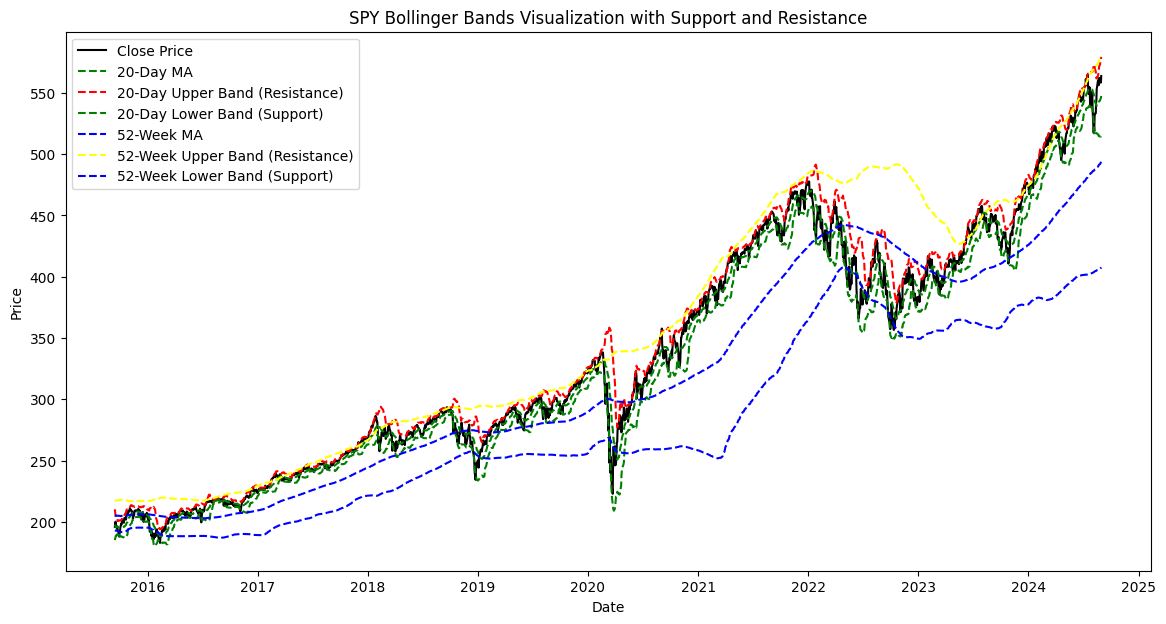

In [12]:
import matplotlib.pyplot as plt

# Create a class to visualize the SPY data with Bollinger Bands
class SPYDataVisualizer:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Ensure all columns used for plotting are numeric
        self.data = self.data.apply(pd.to_numeric, errors='coerce')

        # Check and handle non-finite values (NaN, inf) directly
        self.data = self.data[np.isfinite(self.data['20_Upper_BB']) & np.isfinite(self.data['20_Lower_BB'])]
        self.data = self.data[np.isfinite(self.data['52_Upper_BB']) & np.isfinite(self.data['52_Lower_BB'])]

    def plot_bollinger_bands(self):
        self.clean_data()
        plt.figure(figsize=(14, 7))

        # Plotting the Close price
        plt.plot(self.data.index, self.data['Close'], label='Close Price', color='black')

        # Plotting 20-day moving average and Bollinger Bands
        plt.plot(self.data.index, self.data['20_MA'], label='20-Day MA', color='green', linestyle='--')
        plt.plot(self.data.index, self.data['20_Upper_BB'], color='red', linestyle='--', label='20-Day Upper Band (Resistance)')
        plt.plot(self.data.index, self.data['20_Lower_BB'], color='green', linestyle='--', label='20-Day Lower Band (Support)')

        # Plotting 52-week moving average and Bollinger Bands
        plt.plot(self.data.index, self.data['52_Week_MA'], label='52-Week MA', color='blue', linestyle='--')
        plt.plot(self.data.index, self.data['52_Upper_BB'], color='yellow', linestyle='--', label='52-Week Upper Band (Resistance)')
        plt.plot(self.data.index, self.data['52_Lower_BB'], color='blue', linestyle='--', label='52-Week Lower Band (Support)')

        plt.title('SPY Bollinger Bands Visualization with Support and Resistance')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

# Load the data from the uploaded CSV file
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create an instance of the visualizer class and plot the data
visualizer = SPYDataVisualizer(data)
visualizer.plot_bollinger_bands()